<a href="https://colab.research.google.com/github/PravalikaMuthoju/INTERNSHIP-PROJECTS/blob/main/FJSSP_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0, Makespan: 551, Epsilon: 1.000
Episode 100, Makespan: 570, Epsilon: 0.606
Episode 200, Makespan: 551, Epsilon: 0.367
Episode 300, Makespan: 559, Epsilon: 0.222
Episode 400, Makespan: 584, Epsilon: 0.135
Episode 500, Makespan: 554, Epsilon: 0.082
Episode 600, Makespan: 583, Epsilon: 0.049
Episode 700, Makespan: 564, Epsilon: 0.030
Episode 800, Makespan: 568, Epsilon: 0.018
Episode 900, Makespan: 581, Epsilon: 0.011
Episode 1000, Makespan: 570, Epsilon: 0.010
Episode 1100, Makespan: 573, Epsilon: 0.010
Episode 1200, Makespan: 565, Epsilon: 0.010
Episode 1300, Makespan: 551, Epsilon: 0.010
Episode 1400, Makespan: 568, Epsilon: 0.010
Episode 1500, Makespan: 544, Epsilon: 0.010
Episode 1600, Makespan: 567, Epsilon: 0.010
Episode 1700, Makespan: 549, Epsilon: 0.010
Episode 1800, Makespan: 563, Epsilon: 0.010
Episode 1900, Makespan: 567, Epsilon: 0.010
Episode 2000, Makespan: 574, Epsilon: 0.010
Episode 2100, Makespan: 565, Epsilon: 0.010
Episode 2200, Makespan: 567, Epsilon: 0.010


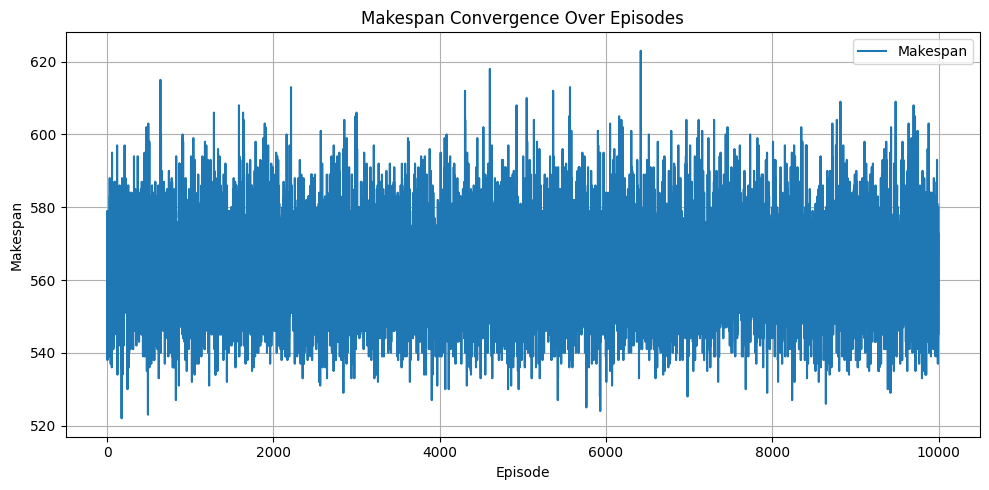

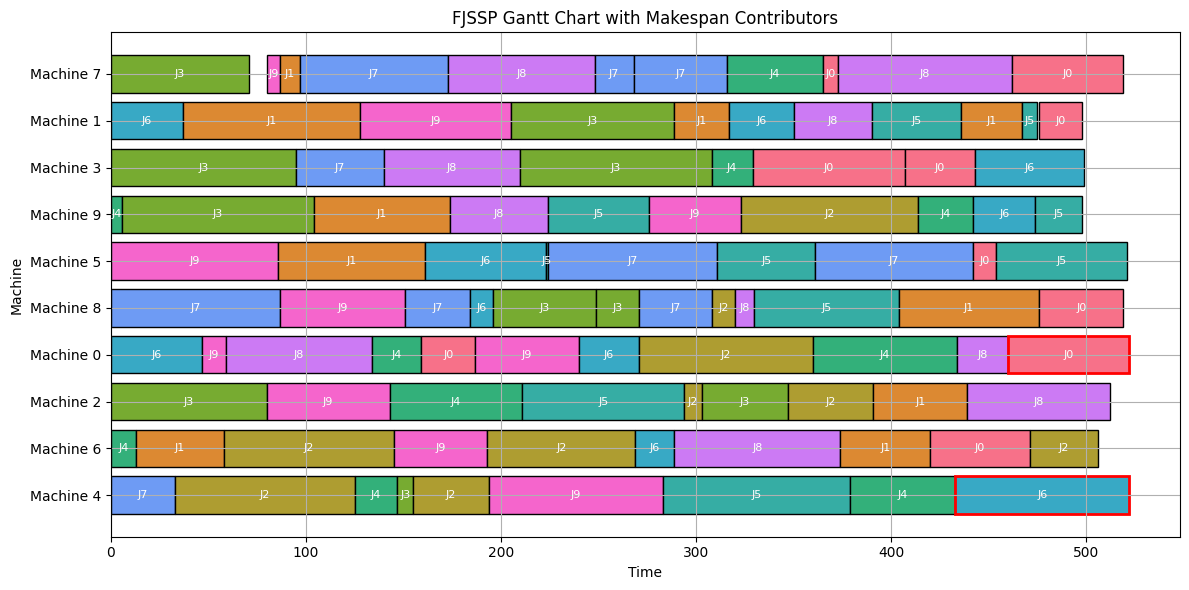

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
from scipy.special import softmax

# Configuration
CONFIG = {
    "seed": 42,        #fixes randomness
    "alpha": 0.1,      # learning rate
    "gamma": 0.95,      # future rewards
    "epsilon": 1.0,      #exploration
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,             # softmax temperature
    "T_decay": 0.995,     # reduces softmax randomness
    "episodes": 10000     # traninig episodes
}

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
Q = defaultdict(lambda: 0.0)

def load_dataset(_, file_name):
    df = pd.read_csv(file_name)
    df["Machine"] = df["Machine"].apply(lambda x: int(x[1:]) if isinstance(x, str) and x.startswith('M') else int(x))
    return df

def initialize_flexible_operations(df, num_machines, all_machines):
    flexible_ops = defaultdict(lambda: defaultdict(list))
    machine_candidates = {}
    machine_loads = defaultdict(int)
    for _, row in df.iterrows():
        job, op, orig_m, pt = int(row["Job ID"]), int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])
        key = (job, op)
        if key not in machine_candidates:
            sorted_machines = sorted(all_machines, key=lambda m: machine_loads[m])
            sampled = sorted_machines[:min(3, len(all_machines))]
            machine_candidates[key] = list(set([orig_m] + sampled))
        for m in machine_candidates[key]:
            flexible_ops[job][op].append((m, pt + random.randint(-1, 2)))
            machine_loads[m] += 1
    return flexible_ops

#Checks  if any is job is free at current time  then the machine is feasible
def get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job):
    feasible = []
    for j in range(num_jobs):
        if job_progress[j] < operations_per_job[j]:
            op = job_progress[j]
            for m, pt in flexible_ops[j][op]:
                if machine_status[m] <= time:
                    feasible.append((j, op, m, pt))
    return feasible

# converts Q-table into probability
def stable_softmax(x, T=1.0):
    x = np.array(x) / T
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def get_state(job_progress, machine_status):
    return (tuple(job_progress), tuple(machine_status))

# Run until all jobs finish by choosing feasible actions, updating status, and learning with Q-values if training

def simulate_fjssp(train=False, flexible_ops=None, num_jobs=None, num_machines=None, operations_per_job=None):
    job_progress = [0] * num_jobs
    machine_status = [0] * num_machines
    schedule = []
    time = 0
    detailed_steps = []

    while any(p < operations_per_job[j] for j, p in enumerate(job_progress)):
        feasible = get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job)
        if not feasible:
            next_time = min([s for s in machine_status if s > time], default=time + 1)
            time = next_time
            continue

        state = get_state(job_progress, machine_status)

        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feasible))
        else:
            q_vals = np.array([Q[(state, j, op, m)] for j, op, m, pt in feasible])
            if train:
                probs = stable_softmax(q_vals, CONFIG["T"])
                idx = np.random.choice(len(feasible), p=probs)
            else:
                idx = np.argmax(q_vals)

        job, op, m, pt = feasible[idx]
        start = max(machine_status[m], time)
        end = start + pt

        if train:
            next_job_progress = job_progress.copy()
            next_machine_status = machine_status.copy()
            next_job_progress[job] += 1
            next_machine_status[m] = end
            next_state = get_state(next_job_progress, next_machine_status)

            idle_time = sum([max(0, time - ms) for ms in machine_status])
            reward = -pt - (start - time) - (0.1 * idle_time)
            next_feasible = get_feasible_actions(next_job_progress, next_machine_status, flexible_ops, end, num_jobs, operations_per_job)
            future_q = [Q.get((next_state, j2, op2, m2), 0) for j2, op2, m2, _ in next_feasible] if next_feasible else [0]
            max_q = max(future_q, default=0)
            Q[(state, job, op, m)] += CONFIG["alpha"] * (reward + CONFIG["gamma"] * max_q - Q[(state, job, op, m)])

        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op, m, start, end))
        detailed_steps.append((time, list(job_progress), list(machine_status), end))

    makespan = max(e for *_, e in schedule) if schedule else float('inf')
    return schedule, makespan, detailed_steps

def train_q_learning(flexible_ops, num_jobs, num_machines, operations_per_job):
    global Q
    makespan_history = []
    best_makespan = float('inf')
    best_schedule = None
    best_steps = []
    initial_makespan = None
    epsilon = CONFIG["epsilon"]
    T = CONFIG["T"]

    for ep in range(CONFIG["episodes"]):
        sched, mkspan, steps = simulate_fjssp(
            train=True, flexible_ops=flexible_ops, num_jobs=num_jobs,
            num_machines=num_machines, operations_per_job=operations_per_job
        )
        makespan_history.append(mkspan)
        if ep == 0:
            initial_makespan = mkspan
        if mkspan < best_makespan:
            best_makespan = mkspan
            best_schedule = sched
            best_steps = steps
        if ep % 100 == 0:
            print(f"Episode {ep}, Makespan: {mkspan}, Epsilon: {epsilon:.3f}")
        epsilon = max(CONFIG["final_epsilon"], epsilon * CONFIG["epsilon_decay"])
        T = max(0.1, T * CONFIG["T_decay"])

    return best_schedule, best_makespan, initial_makespan, makespan_history, best_steps

def plot_gantt_chart(schedule_df, num_machines, num_jobs):
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", num_jobs)
    for _, row in schedule_df.iterrows():
        color = colors[row["Job ID"]]
        edge = 'red' if row["Contributes to Makespan"] else 'black'
        lw = 2 if row["Contributes to Makespan"] else 1
        plt.barh(y=f"Machine {row['Machine']}", width=row["End"] - row["Start"],
                 left=row["Start"], color=color, edgecolor=edge, linewidth=lw)
        plt.text(x=row["Start"] + (row["End"] - row["Start"]) / 2,
                 y=f"Machine {row['Machine']}",
                 s=f"J{row['Job ID']}",
                 va='center', ha='center', color='white', fontsize=8)
    plt.title("FJSSP Gantt Chart with Makespan Contributors")
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_makespan_history(makespan_history):
    plt.figure(figsize=(10, 5))
    plt.plot(makespan_history, label="Makespan")
    plt.title("Makespan Convergence Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Makespan")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    df = load_dataset(".", "FT10_Dataset.csv")  # Make sure FT10_Dataset.csv is in the same folder
    num_jobs = df["Job ID"].nunique()
    num_machines = df["Machine"].nunique()
    all_machines = list(range(num_machines))
    operations_per_job = df.groupby("Job ID")["Operation"].max().to_dict()
    operations_per_job = {k: v + 1 for k, v in operations_per_job.items()}
    flexible_ops = initialize_flexible_operations(df, num_machines, all_machines)

    best_schedule, best_makespan, initial_makespan, makespan_history, best_steps = train_q_learning(
        flexible_ops, num_jobs, num_machines, operations_per_job
    )

    sched_df = pd.DataFrame(best_schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
    sched_df.sort_values(by="Start", inplace=True)
    sched_df["Current Makespan"] = sched_df["End"].cummax()
    sched_df["Contributes to Makespan"] = sched_df["End"] == best_makespan
    used_time = sched_df["End"].sub(sched_df["Start"]).sum()
    idle_machines = num_machines * best_makespan - used_time
    machine_utilization = used_time / (num_machines * best_makespan)

    print("\n🔧 Job-Machine-Time Assignments:")
    print(sched_df.to_string(index=False))
    print(f"\n🚀 Initial Random Makespan: {initial_makespan}")
    print(f"📊 Total Optimized Makespan: {best_makespan}")
    print(f"📉 Makespan Reduced By: {initial_makespan - best_makespan} time units")
    print(f"🛠 Idle Machine Time Units: {idle_machines}")
    print(f"📈 Machine Utilization: {machine_utilization:.2%}")

    plot_makespan_history(makespan_history)
    plot_gantt_chart(sched_df, num_machines, num_jobs)

if __name__ == "__main__":
    main()


Saving SELECTED_16_DATASETS.zip to SELECTED_16_DATASETS (2).zip
Episode 0: Makespan = 30.00
Episode 100: Makespan = 31.00
Episode 200: Makespan = 31.00
Episode 300: Makespan = 33.00
Episode 400: Makespan = 32.00
Episode 500: Makespan = 29.00
Episode 600: Makespan = 33.00
Episode 700: Makespan = 31.00
Episode 800: Makespan = 31.00
Episode 900: Makespan = 31.00
Episode 1000: Makespan = 30.00
Episode 1100: Makespan = 31.00
Episode 1200: Makespan = 38.00
Episode 1300: Makespan = 35.00
Episode 1400: Makespan = 32.00
Episode 1500: Makespan = 31.00
Episode 1600: Makespan = 28.00
Episode 1700: Makespan = 34.00
Episode 1800: Makespan = 31.00
Episode 1900: Makespan = 32.00
Episode 2000: Makespan = 30.00
Episode 2100: Makespan = 30.00
Episode 2200: Makespan = 32.00
Episode 2300: Makespan = 32.00
Episode 2400: Makespan = 30.00
Episode 2500: Makespan = 28.00
Episode 2600: Makespan = 31.00
Episode 2700: Makespan = 31.00
Episode 2800: Makespan = 34.00
Episode 2900: Makespan = 31.00
Episode 3000: Make

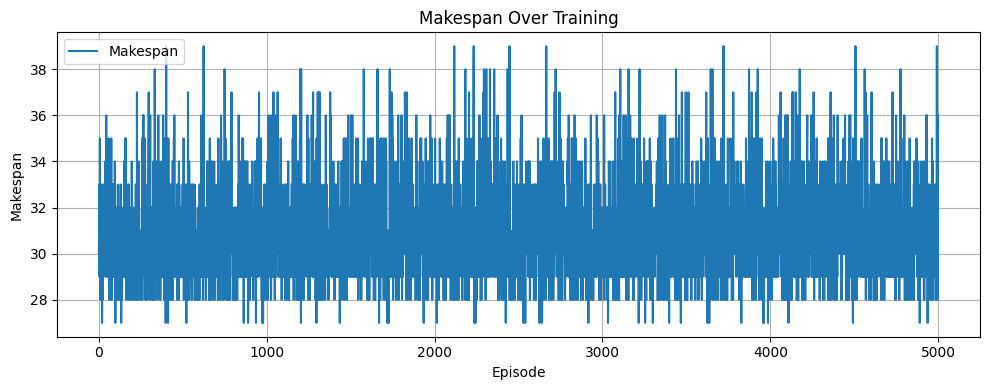

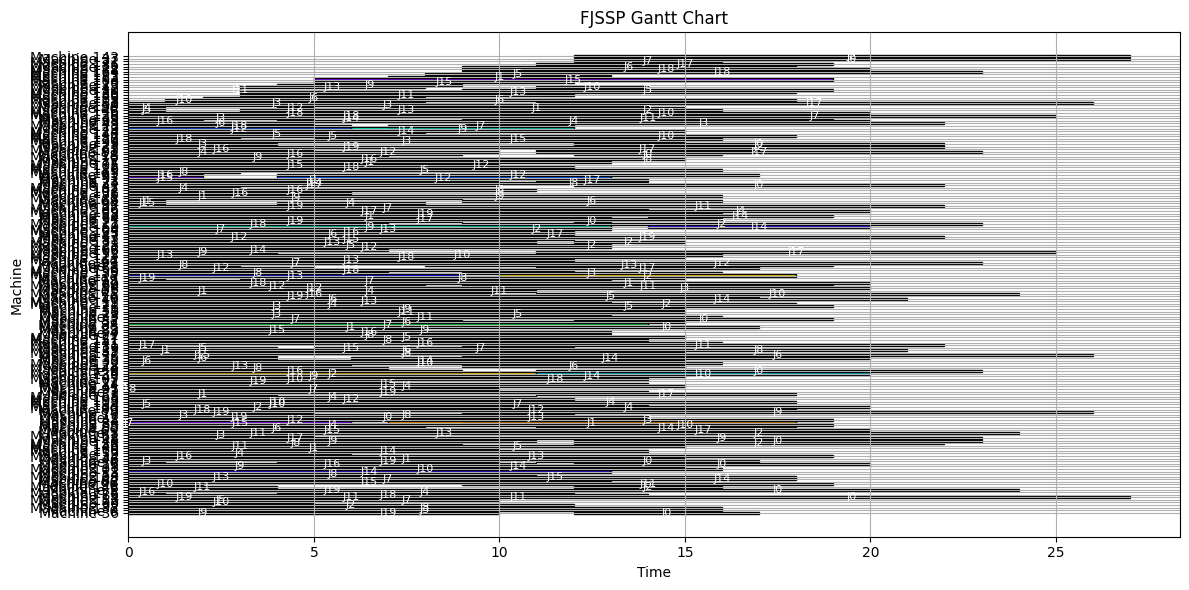

In [ ]:
# === STEP 1: Upload ZIP ===
from google.colab import files
uploaded = files.upload()  # Upload SELECTED_16_DATASETS.zip

import os, zipfile, numpy as np, pandas as pd
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 2: Extract ===
zip_path = next(iter(uploaded))
extract_path = "/content/fjsp_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === STEP 3: Select and Load One Dataset ===
sample_file = os.path.join(extract_path, "dmu20_15.npy")  # You can change this to any file in the zip
data = np.load(sample_file, allow_pickle=True)
instance = data[0]  # First problem instance
machines = instance[0]
processing_times = instance[1]

records = []
num_jobs, num_operations = machines.shape
for job_id in range(num_jobs):
    for op_id in range(num_operations):
        machine = machines[job_id][op_id]
        pt = processing_times[job_id][op_id]
        if pt > 0:
            records.append({
                "Job ID": job_id,
                "Operation": op_id,
                "Machine": int(machine),
                "Processing Time": int(pt)
            })
df = pd.DataFrame(records)

# === STEP 4: FJSSP Q-learning Setup ===
CONFIG = {
    "seed": 42,
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,
    "T_decay": 0.995,
    "episodes": 5000  # reduce for quick test
}

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
Q = defaultdict(lambda: 0.0)

def initialize_flexible_operations(df, num_machines, all_machines):
    flexible_ops = defaultdict(lambda: defaultdict(list))
    machine_candidates = {}
    machine_loads = defaultdict(int)
    max_machine_idx = 0 # Track maximum machine index
    for _, row in df.iterrows():
        job, op, orig_m, pt = int(row["Job ID"]), int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])
        key = (job, op)
        if key not in machine_candidates:
            sorted_machines = sorted(all_machines, key=lambda m: machine_loads[m])
            sampled = sorted_machines[:min(3, len(all_machines))]
            machine_candidates[key] = list(set([orig_m] + sampled))
        for m in machine_candidates[key]:
            flexible_ops[job][op].append((m, pt + random.randint(-1, 2)))
            machine_loads[m] += 1
            max_machine_idx = max(max_machine_idx, m) # Update max machine index
    return flexible_ops, max_machine_idx

def get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job):
    feasible = []
    for j in range(num_jobs):
        if job_progress[j] < operations_per_job[j]:
            op = job_progress[j]
            for m, pt in flexible_ops[j][op]:
                if machine_status[m] <= time:
                    feasible.append((j, op, m, pt))
    return feasible

def stable_softmax(x, T=1.0):
    x = np.array(x) / T
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def get_state(job_progress, machine_status):
    return (tuple(job_progress), tuple(machine_status))

def simulate_fjssp(train, flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx):
    job_progress = [0] * num_jobs
    machine_status = [0] * (max_machine_idx + 1) # Initialize based on max machine index
    schedule = []
    time = 0
    while any(p < operations_per_job[j] for j, p in enumerate(job_progress)):
        feasible = get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job)
        if not feasible:
            time = min([s for s in machine_status if s > time], default=time + 1)
            continue
        state = get_state(job_progress, machine_status)
        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feasible))
        else:
            q_vals = np.array([Q[(state, j, op, m)] for j, op, m, pt in feasible])
            if train:
                probs = stable_softmax(q_vals, CONFIG["T"])
                idx = np.random.choice(len(feasible), p=probs)
            else:
                idx = np.argmax(q_vals)
        job, op, m, pt = feasible[idx]
        start = max(machine_status[m], time)
        end = start + pt
        if train:
            next_job_progress = job_progress.copy()
            next_machine_status = machine_status.copy()
            next_job_progress[job] += 1
            next_machine_status[m] = end
            next_state = get_state(next_job_progress, next_machine_status)
            reward = -pt - (start - time)
            next_feasible = get_feasible_actions(next_job_progress, next_machine_status, flexible_ops, end, num_jobs, operations_per_job)
            future_q = [Q.get((next_state, j2, op2, m2), 0) for j2, op2, m2, _ in next_feasible] if next_feasible else [0]
            max_q = max(future_q)
            Q[(state, job, op, m)] += CONFIG["alpha"] * (reward + CONFIG["gamma"] * max_q - Q[(state, job, op, m)])
        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op, m, start, end))
    makespan = max(e for *_, e in schedule)
    return schedule, makespan

def train_q_learning(flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx):
    makespan_history = []
    best_makespan = float('inf')
    best_schedule = []
    for ep in range(CONFIG["episodes"]):
        sched, mkspan = simulate_fjssp(True, flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx)
        makespan_history.append(mkspan)
        if mkspan < best_makespan:
            best_makespan = mkspan
            best_schedule = sched
        CONFIG["epsilon"] = max(CONFIG["final_epsilon"], CONFIG["epsilon"] * CONFIG["epsilon_decay"])
        CONFIG["T"] = max(0.1, CONFIG["T"] * CONFIG["T_decay"])
        if ep % 100 == 0:
            print(f"Episode {ep}: Makespan = {mkspan:.2f}")
    return best_schedule, best_makespan, makespan_history

def plot_gantt_chart(schedule, num_jobs, num_machines):
    df = pd.DataFrame(schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
    colors = sns.color_palette("hsv", num_jobs)
    plt.figure(figsize=(12, 6))
    for _, row in df.iterrows():
        j = row["Job ID"]
        m = row["Machine"]
        plt.barh(f"Machine {m}", row["End"] - row["Start"], left=row["Start"],
                 color=colors[j], edgecolor='black')
        plt.text(row["Start"] + (row["End"] - row["Start"]) / 2, f"Machine {m}", f"J{j}",
                 va='center', ha='center', color='white', fontsize=8)
    plt.title("FJSSP Gantt Chart")
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_makespan_history(makespan_history):
    plt.figure(figsize=(10, 4))
    plt.plot(makespan_history, label='Makespan')
    plt.xlabel("Episode")
    plt.ylabel("Makespan")
    plt.title("Makespan Over Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === STEP 5: Run Training ===
num_jobs = df["Job ID"].nunique()
num_machines = df["Machine"].nunique()
all_machines = list(range(num_machines))
operations_per_job = df.groupby("Job ID")["Operation"].max().to_dict()
operations_per_job = {k: v + 1 for k, v in operations_per_job.items()}
flexible_ops, max_machine_idx = initialize_flexible_operations(df, num_machines, all_machines)

best_schedule, best_makespan, makespan_history = train_q_learning(flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx)

print(f"\nBest Makespan: {best_makespan}")
plot_makespan_history(makespan_history)
plot_gantt_chart(best_schedule, num_jobs, max_machine_idx + 1) # Pass max_machine_idx + 1 for plotting

Saving SELECTED_16_DATASETS.zip to SELECTED_16_DATASETS (3).zip
Episode 0: Makespan = 30.00
Episode 100: Makespan = 31.00
Episode 200: Makespan = 31.00
Episode 300: Makespan = 33.00
Episode 400: Makespan = 32.00
Episode 500: Makespan = 29.00
Episode 600: Makespan = 33.00
Episode 700: Makespan = 31.00
Episode 800: Makespan = 31.00
Episode 900: Makespan = 31.00

🔧 Job-Machine-Time Assignments:
 Job ID  Operation  Machine  Start  End
      9          0       36      0    4
      3          0        0      0   16
      8          0      132      0   16
      2          0       92      0   12
     10          0       90      0    5
      5          0      152      0    5
     19          0       14      0    3
     18          0       85      0   14
     16          0      176      0    1
     19          1        5      0   11
     11          0      148      0    4
     10          1       96      0    2
      9          2       44      0   11
     17          0       28      0    9
     

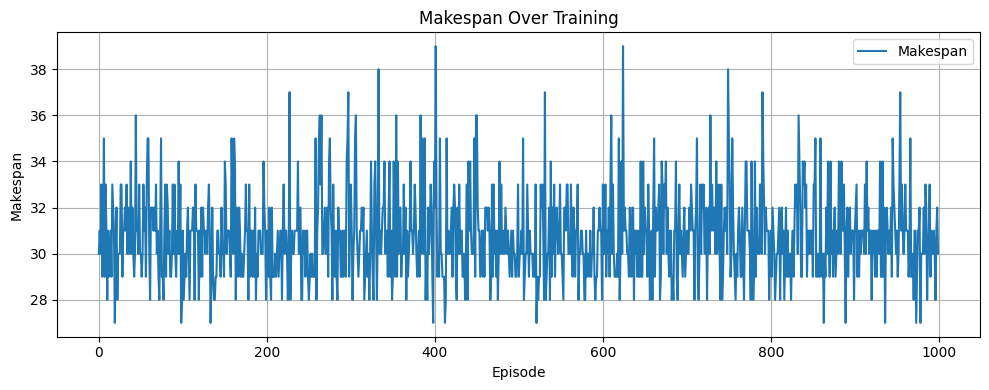

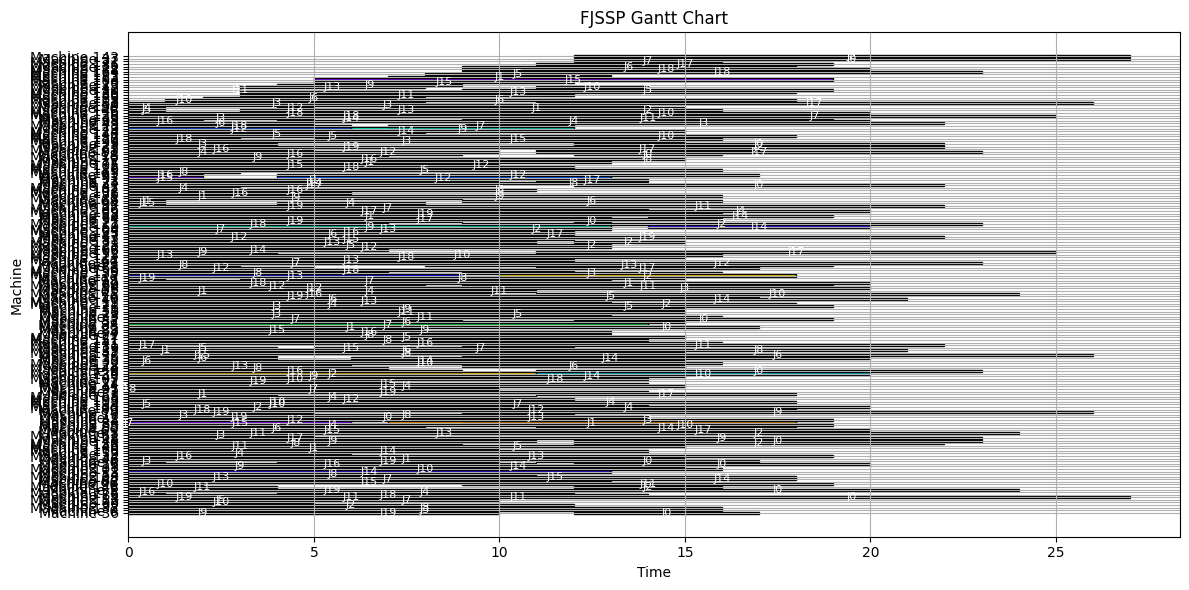

In [ ]:
# === STEP 1: Upload ZIP ===
from google.colab import files
uploaded = files.upload()  # Upload SELECTED_16_DATASETS.zip

import os, zipfile, numpy as np, pandas as pd
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 2: Extract ===
zip_path = next(iter(uploaded))
extract_path = "/content/fjsp_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === STEP 3: Load First Instance from a Dataset ===
sample_file = os.path.join(extract_path, "dmu20_15.npy")  # Change file if needed
data = np.load(sample_file, allow_pickle=True)
instance = data[0]  # First problem instance
machines = instance[0]
processing_times = instance[1]

records = []
num_jobs, num_operations = machines.shape
for job_id in range(num_jobs):
    for op_id in range(num_operations):
        machine = machines[job_id][op_id]
        pt = processing_times[job_id][op_id]
        if pt > 0:
            records.append({
                "Job ID": job_id,
                "Operation": op_id,
                "Machine": int(machine),
                "Processing Time": int(pt)
            })
df = pd.DataFrame(records)

# === STEP 4: Q-Learning FJSSP Setup ===
CONFIG = {
    "seed": 42,
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,
    "T_decay": 0.995,
    "episodes": 1000
}

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
Q = defaultdict(lambda: 0.0)

def initialize_flexible_operations(df, num_machines, all_machines):
    flexible_ops = defaultdict(lambda: defaultdict(list))
    machine_candidates = {}
    machine_loads = defaultdict(int)
    max_machine_idx = 0
    for _, row in df.iterrows():
        job, op, orig_m, pt = int(row["Job ID"]), int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])
        key = (job, op)
        if key not in machine_candidates:
            sorted_machines = sorted(all_machines, key=lambda m: machine_loads[m])
            sampled = sorted_machines[:min(3, len(all_machines))]
            machine_candidates[key] = list(set([orig_m] + sampled))
        for m in machine_candidates[key]:
            flexible_ops[job][op].append((m, pt + random.randint(-1, 2)))
            machine_loads[m] += 1
            max_machine_idx = max(max_machine_idx, m)
    return flexible_ops, max_machine_idx

def get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job):
    feasible = []
    for j in range(num_jobs):
        if job_progress[j] < operations_per_job[j]:
            op = job_progress[j]
            for m, pt in flexible_ops[j][op]:
                if machine_status[m] <= time:
                    feasible.append((j, op, m, pt))
    return feasible

def stable_softmax(x, T=1.0):
    x = np.array(x) / T
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def get_state(job_progress, machine_status):
    return (tuple(job_progress), tuple(machine_status))

def simulate_fjssp(train, flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx):
    job_progress = [0] * num_jobs
    machine_status = [0] * (max_machine_idx + 1)
    schedule = []
    time = 0
    while any(p < operations_per_job[j] for j, p in enumerate(job_progress)):
        feasible = get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job)
        if not feasible:
            time = min([s for s in machine_status if s > time], default=time + 1)
            continue
        state = get_state(job_progress, machine_status)
        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feasible))
        else:
            q_vals = np.array([Q[(state, j, op, m)] for j, op, m, pt in feasible])
            if train:
                probs = stable_softmax(q_vals, CONFIG["T"])
                idx = np.random.choice(len(feasible), p=probs)
            else:
                idx = np.argmax(q_vals)
        job, op, m, pt = feasible[idx]
        start = max(machine_status[m], time)
        end = start + pt
        if train:
            next_job_progress = job_progress.copy()
            next_machine_status = machine_status.copy()
            next_job_progress[job] += 1
            next_machine_status[m] = end
            next_state = get_state(next_job_progress, next_machine_status)
            reward = -pt - (start - time)
            next_feasible = get_feasible_actions(next_job_progress, next_machine_status, flexible_ops, end, num_jobs, operations_per_job)
            future_q = [Q.get((next_state, j2, op2, m2), 0) for j2, op2, m2, _ in next_feasible] if next_feasible else [0]
            max_q = max(future_q)
            Q[(state, job, op, m)] += CONFIG["alpha"] * (reward + CONFIG["gamma"] * max_q - Q[(state, job, op, m)])
        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op, m, start, end))
    makespan = max(e for *_, e in schedule)
    return schedule, makespan

def train_q_learning(flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx):
    makespan_history = []
    best_makespan = float('inf')
    best_schedule = []
    for ep in range(CONFIG["episodes"]):
        sched, mkspan = simulate_fjssp(True, flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx)
        makespan_history.append(mkspan)
        if mkspan < best_makespan:
            best_makespan = mkspan
            best_schedule = sched
        CONFIG["epsilon"] = max(CONFIG["final_epsilon"], CONFIG["epsilon"] * CONFIG["epsilon_decay"])
        CONFIG["T"] = max(0.1, CONFIG["T"] * CONFIG["T_decay"])
        if ep % 100 == 0:
            print(f"Episode {ep}: Makespan = {mkspan:.2f}")
    return best_schedule, best_makespan, makespan_history

def plot_gantt_chart(schedule, num_jobs, num_machines):
    df = pd.DataFrame(schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
    colors = sns.color_palette("hsv", num_jobs)
    plt.figure(figsize=(12, 6))
    for _, row in df.iterrows():
        j = row["Job ID"]
        m = row["Machine"]
        plt.barh(f"Machine {m}", row["End"] - row["Start"], left=row["Start"],
                 color=colors[j], edgecolor='black')
        plt.text(row["Start"] + (row["End"] - row["Start"]) / 2, f"Machine {m}", f"J{j}",
                 va='center', ha='center', color='white', fontsize=8)
    plt.title("FJSSP Gantt Chart")
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_makespan_history(makespan_history):
    plt.figure(figsize=(10, 4))
    plt.plot(makespan_history, label='Makespan')
    plt.xlabel("Episode")
    plt.ylabel("Makespan")
    plt.title("Makespan Over Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === STEP 5: Run Training and Print Metrics ===
num_jobs = df["Job ID"].nunique()
num_machines = df["Machine"].nunique()
all_machines = list(range(num_machines))
operations_per_job = df.groupby("Job ID")["Operation"].max().to_dict()
operations_per_job = {k: v + 1 for k, v in operations_per_job.items()}
flexible_ops, max_machine_idx = initialize_flexible_operations(df, num_machines, all_machines)

best_schedule, best_makespan, makespan_history = train_q_learning(
    flexible_ops, num_jobs, num_machines, operations_per_job, max_machine_idx
)

# === STEP 6: Metrics & Visualization ===
initial_makespan = makespan_history[0]
average_makespan = sum(makespan_history) / len(makespan_history)
makespan_gap = initial_makespan - best_makespan
gap_percent = (makespan_gap / initial_makespan) * 100 if initial_makespan != 0 else 0

print("\n🔧 Job-Machine-Time Assignments:")
schedule_df = pd.DataFrame(best_schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
print(schedule_df.sort_values(by="Start").to_string(index=False))

print(f"\n🚀 Initial Random Makespan: {initial_makespan}")
print(f"🏁 Optimized Best Makespan: {best_makespan}")
print(f"📉 Average Makespan Over {CONFIG['episodes']} Episodes: {average_makespan:.2f}")
print(f"📊 Makespan Improvement: {makespan_gap} time units")
print(f"📈 Improvement Percentage: {gap_percent:.2f}%")

plot_makespan_history(makespan_history)
plot_gantt_chart(best_schedule, num_jobs, max_machine_idx + 1)


Saving SELECTED_16_DATASETS.zip to SELECTED_16_DATASETS (5).zip
Found 16 dataset files.

🚀 Training on: dmu20_15.npy


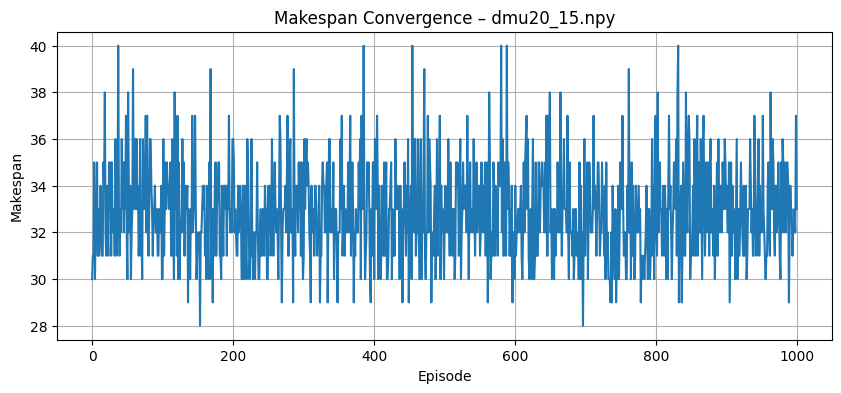

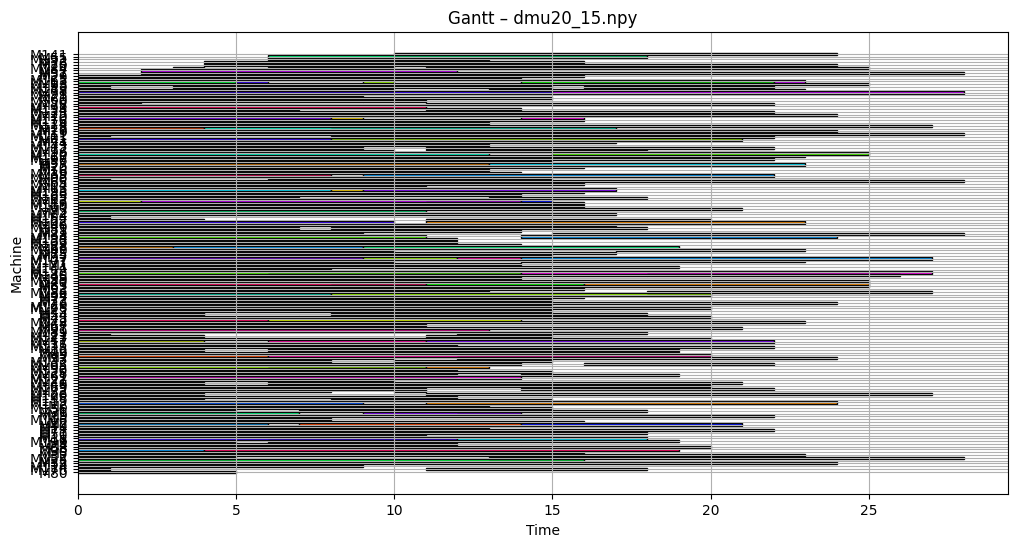


🚀 Training on: dmu20_20.npy

🚀 Training on: dmu30_15.npy

🚀 Training on: dmu30_20.npy

🚀 Training on: dmu40_15.npy


KeyboardInterrupt: 

In [ ]:
# === STEP 1: Upload ZIP ===
from google.colab import files
uploaded = files.upload()  # Upload SELECTED_16_DATASETS.zip

# === STEP 2: Import Libraries ===
import os, zipfile, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === STEP 3: Extract ZIP ===
zip_path = next(iter(uploaded))
extract_path = "/content/fjsp_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

npy_files = sorted([f for f in os.listdir(extract_path) if f.endswith(".npy")])
print(f"Found {len(npy_files)} dataset files.")

# === STEP 4: Configuration ===
CONFIG = {
    "seed": 42,
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,
    "T_decay": 0.995,
    "episodes": 1000,
    "plot_only_best": True
}
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# === STEP 5: Q-Learning Helpers ===
def initialize_flexible_operations(df, num_machines, all_machines):
    flex_ops, machine_candidates, machine_loads = defaultdict(lambda: defaultdict(list)), {}, defaultdict(int)
    max_idx = 0
    for _, row in df.iterrows():
        job, op, m0, pt = map(int, (row["Job ID"], row["Operation"], row["Machine"], row["Processing Time"]))
        key = (job, op)
        if key not in machine_candidates:
            sorted_m = sorted(all_machines, key=lambda k: machine_loads[k])
            machine_candidates[key] = list({m0, *sorted_m[:3]})
        for m in machine_candidates[key]:
            flex_ops[job][op].append((m, pt + random.randint(-1, 2)))
            machine_loads[m] += 1
            max_idx = max(max_idx, m)
    return flex_ops, max_idx

def get_feasible_actions(job_prog, mach_stat, flex_ops, t, n_jobs, ops_per_job):
    feas = []
    for j in range(n_jobs):
        if job_prog[j] < ops_per_job[j]:
            op = job_prog[j]
            for m, pt in flex_ops[j][op]:
                if mach_stat[m] <= t:
                    feas.append((j, op, m, pt))
    return feas

def stable_softmax(x, T=1.0):
    x = np.array(x) / T
    x = x - x.max()
    e = np.exp(x)
    return e / e.sum()

def get_state(job_prog, mach_stat):
    return (tuple(job_prog), tuple(mach_stat))

def simulate_fjssp(train, flex_ops, n_jobs, n_machs, ops_per_job, max_midx, Q):
    job_prog = [0] * n_jobs
    mach_stat = [0] * (max_midx + 1)
    sched = []
    t = 0
    while any(job_prog[j] < ops_per_job[j] for j in range(n_jobs)):
        feas = get_feasible_actions(job_prog, mach_stat, flex_ops, t, n_jobs, ops_per_job)
        if not feas:
            t = min([s for s in mach_stat if s > t], default=t + 1)
            continue
        state = get_state(job_prog, mach_stat)
        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feas))
        else:
            q_vals = np.array([Q[(state, j, o, m)] for j, o, m, _ in feas])
            idx = np.random.choice(len(feas), p=stable_softmax(q_vals, CONFIG["T"])) if train else q_vals.argmax()
        j, o, m, pt = feas[idx]
        start, end = max(mach_stat[m], t), max(mach_stat[m], t) + pt
        if train:
            nxt_job, nxt_mach = job_prog.copy(), mach_stat.copy()
            nxt_job[j] += 1
            nxt_mach[m] = end
            nxt_state = get_state(nxt_job, nxt_mach)
            rew = -pt - (start - t)
            nxt_feas = get_feasible_actions(nxt_job, nxt_mach, flex_ops, end, n_jobs, ops_per_job)
            future_q = max([Q.get((nxt_state, *f[:3]), 0) for f in nxt_feas] or [0])
            Q[(state, j, o, m)] += CONFIG["alpha"] * (rew + CONFIG["gamma"] * future_q - Q[(state, j, o, m)])
        job_prog[j] += 1
        mach_stat[m] = end
        sched.append((j, o, m, start, end))
    return sched, max(e for *_, e in sched)

def train_dataset(df, tag):
    Q = defaultdict(lambda: 0.0)
    eps, temp = CONFIG["epsilon"], CONFIG["T"]
    n_jobs = df["Job ID"].nunique()
    machs = sorted(df["Machine"].unique())
    ops_per_job = df.groupby("Job ID")["Operation"].max().add(1).to_dict()
    flex_ops, max_midx = initialize_flexible_operations(df, len(machs), machs)

    makespan_hist = []
    best_mk, best_sched = float("inf"), []
    for ep in range(CONFIG["episodes"]):
        sched, mk = simulate_fjssp(True, flex_ops, n_jobs, len(machs), ops_per_job, max_midx, Q)
        makespan_hist.append(mk)
        if mk < best_mk:
            best_mk, best_sched = mk, sched
        eps = max(CONFIG["final_epsilon"], eps * CONFIG["epsilon_decay"])
        temp = max(0.1, temp * CONFIG["T_decay"])
        CONFIG["epsilon"], CONFIG["T"] = eps, temp
    return {
        "dataset": tag,
        "initial": makespan_hist[0],
        "best": best_mk,
        "average": sum(makespan_hist) / len(makespan_hist),
        "gap_abs": makespan_hist[0] - best_mk,
        "gap_pct": 100 * (makespan_hist[0] - best_mk) / makespan_hist[0] if makespan_hist[0] else 0,
        "history": makespan_hist,
        "schedule": best_sched,
        "n_jobs": n_jobs,
        "max_machine": max_midx + 1
    }

def plot_history(hist, name):
    plt.figure(figsize=(10, 4))
    plt.plot(hist)
    plt.title(f"Makespan Convergence – {name}")
    plt.xlabel("Episode")
    plt.ylabel("Makespan")
    plt.grid(True)
    plt.show()

def plot_gantt(sched, n_jobs, n_machs, title):
    df = pd.DataFrame(sched, columns=["Job", "Op", "Mach", "Start", "End"])
    colors = sns.color_palette("hsv", n_jobs)
    plt.figure(figsize=(12, 6))
    for _, r in df.iterrows():
        plt.barh(f"M{r.Mach}", r.End - r.Start, left=r.Start, color=colors[r.Job], edgecolor="black")
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.title(title)
    plt.grid(True)
    plt.show()

# === STEP 6: Train on ALL datasets ===
results = []
for fname in npy_files:
    print(f"\n🚀 Training on: {fname}")
    data = np.load(os.path.join(extract_path, fname), allow_pickle=True)
    instance = data[0]
    machines, times = instance
    records = []
    for j in range(machines.shape[0]):
        for o in range(machines.shape[1]):
            m, pt = int(machines[j, o]), int(times[j, o])
            if pt > 0:
                records.append({"Job ID": j, "Operation": o, "Machine": m, "Processing Time": pt})
    df = pd.DataFrame(records)
    res = train_dataset(df, fname)
    results.append(res)

    if (CONFIG["plot_only_best"] and
        res["best"] == min(r["best"] for r in results)):
        plot_history(res["history"], fname)
        plot_gantt(res["schedule"], res["n_jobs"], res["max_machine"], f"Gantt – {fname}")

# === STEP 7: Summary Table ===
summary = pd.DataFrame([{k: v for k, v in r.items() if k not in ("history", "schedule", "n_jobs", "max_machine")}
                        for r in results])
print("\n📊 Summary:")
print(summary.to_string(index=False, formatters={
    "initial": "{:.0f}".format, "best": "{:.0f}".format,
    "average": "{:.1f}".format, "gap_abs": "{:.0f}".format,
    "gap_pct": "{:.1f}".format}))


In [ ]:
# === STEP 1: Upload ZIP ===
from google.colab import files
uploaded = files.upload()  # Upload SELECTED_16_DATASETS.zip

import os, zipfile, time, random
import numpy as np
import pandas as pd
from collections import defaultdict

# === STEP 2: Extract ZIP ===
zip_path = next(iter(uploaded))
extract_path = "/content/fjsp_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

files_in_zip = sorted([f for f in os.listdir(extract_path) if f.endswith(".npy")])

CONFIG = {
    "seed": 42,
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,
    "T_decay": 0.995,
    "episodes": 100
}
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# === Helper Functions ===
def initialize_flexible_operations(df, all_machines):
    flex_ops = defaultdict(lambda: defaultdict(list))
    machine_loads = defaultdict(int)
    max_machine_idx = 0
    for _, row in df.iterrows():
        j, o, m, pt = int(row["Job ID"]), int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])
        sampled = sorted(all_machines, key=lambda x: machine_loads[x])[:3]
        machines = list(set([m] + sampled))
        for machine in machines:
            flex_ops[j][o].append((machine, pt + random.randint(-1, 2)))
            machine_loads[machine] += 1
            max_machine_idx = max(max_machine_idx, machine)
    return flex_ops, max_machine_idx

def get_feasible(job_progress, machine_status, flex_ops, time, num_jobs, operations_per_job):
    feasible = []
    for j in range(num_jobs):
        if job_progress[j] < operations_per_job[j]:
            op = job_progress[j]
            for m, pt in flex_ops[j][op]:
                if machine_status[m] <= time:
                    feasible.append((j, op, m, pt))
    return feasible

def stable_softmax(x, T=1.0):
    x = np.array(x) / T
    x -= np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def get_state(job_progress, machine_status):
    return (tuple(job_progress), tuple(machine_status))

def simulate(train, flex_ops, num_jobs, operations_per_job, max_machine_index, Q):
    job_progress = [0] * num_jobs
    machine_status = [0] * (max_machine_index + 1)
    schedule = []
    time_now = 0

    while any(job_progress[j] < operations_per_job[j] for j in range(num_jobs)):
        feasible = get_feasible(job_progress, machine_status, flex_ops, time_now, num_jobs, operations_per_job)
        if not feasible:
            time_now = min([s for s in machine_status if s > time_now], default=time_now + 1)
            continue
        state = get_state(job_progress, machine_status)
        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feasible))
        else:
            q_vals = [Q[(state, j, op, m)] for j, op, m, pt in feasible]
            idx = np.random.choice(len(feasible), p=stable_softmax(q_vals, CONFIG["T"])) if train else np.argmax(q_vals)
        j, op, m, pt = feasible[idx]
        start = max(machine_status[m], time_now)
        end = start + pt

        if train:
            new_job_progress = job_progress.copy()
            new_machine_status = machine_status.copy()
            new_job_progress[j] += 1
            new_machine_status[m] = end
            next_state = get_state(new_job_progress, new_machine_status)
            next_feasible = get_feasible(new_job_progress, new_machine_status, flex_ops, end, num_jobs, operations_per_job)
            future_q = [Q.get((next_state, j2, op2, m2), 0) for j2, op2, m2, _ in next_feasible] if next_feasible else [0]
            reward = -pt - (start - time_now)
            Q[(state, j, op, m)] += CONFIG["alpha"] * (reward + CONFIG["gamma"] * max(future_q) - Q[(state, j, op, m)])

        job_progress[j] += 1
        machine_status[m] = end
        schedule.append((j, op, m, start, end))

    makespan = max(e for *_, e in schedule)
    used_machines = sum(1 for t in machine_status if t > 0)
    return schedule, makespan, used_machines

# === Run over all datasets ===
total_gap = 0
total_time = 0
total_used_machines = 0
summary = []

for file in files_in_zip:
    path = os.path.join(extract_path, file)
    data = np.load(path, allow_pickle=True)[0]
    machines, times = data
    num_jobs, num_ops = machines.shape

    records = []
    for j in range(num_jobs):
        for o in range(num_ops):
            m = machines[j][o]
            pt = times[j][o]
            if pt > 0:
                records.append({"Job ID": j, "Operation": o, "Machine": int(m), "Processing Time": int(pt)})

    df = pd.DataFrame(records)
    ops_per_job = df.groupby("Job ID")["Operation"].max().add(1).to_dict()
    all_machines = sorted(df["Machine"].unique())
    flex_ops, max_midx = initialize_flexible_operations(df, all_machines)

    Q = defaultdict(lambda: 0.0)
    makespans = []
    start_time = time.time()

    for _ in range(CONFIG["episodes"]):
        sched, mk, _ = simulate(True, flex_ops, num_jobs, ops_per_job, max_midx, Q)
        makespans.append(mk)
        CONFIG["epsilon"] = max(CONFIG["final_epsilon"], CONFIG["epsilon"] * CONFIG["epsilon_decay"])
        CONFIG["T"] = max(0.1, CONFIG["T"] * CONFIG["T_decay"])

    runtime = time.time() - start_time
    sched, best_mk, used_machines = simulate(False, flex_ops, num_jobs, ops_per_job, max_midx, Q)

    init_mk = makespans[0]
    avg_mk = sum(makespans) / len(makespans)
    gap = init_mk - best_mk
    gap_pct = (gap / init_mk) * 100 if init_mk else 0

    total_gap += gap
    total_time += runtime
    total_used_machines += used_machines

    summary.append({
        "Dataset": file,
        "Initial": init_mk,
        "Best": best_mk,
        "Average": round(avg_mk, 2),
        "Gap": gap,
        "Gap %": round(gap_pct, 2),
        "Used Machines": used_machines,
        "Time": round(runtime, 2)
    })

# === Print Summary ===
for s in summary:
    print(f"\n📂 Dataset: {s['Dataset']}")
    print(f"Initial Random Makespan: {s['Initial']}")
    print(f"🏑 Optimized Best Makespan: {s['Best']}")
    print(f"📉 Average Makespan Over {CONFIG['episodes']} Episodes: {s['Average']}")
    print(f"📊 Makespan Improvement: {s['Gap']} time units")
    print(f"📈 Improvement Percentage: {s['Gap %']}%")
    print(f"🛠️ Machines Used: {s['Used Machines']}")
    print(f"⏱️ Time Taken: {s['Time']} seconds")

print("\n📉 Average Gap Across Datasets:", round(total_gap / len(summary), 2))
print("⏱️ Average Time Across Datasets:", round(total_time / len(summary), 2), "seconds")
print("🛠️ Average Machines Used:", round(total_used_machines / len(summary), 2))

# === Find Best Optimized and Worst Initial ===
best_optimized = min(summary, key=lambda x: x["Best"])
worst_initial = max(summary, key=lambda x: x["Initial"])

print("\n🏆 Best Optimized Dataset:")
print(f"📂 Dataset: {best_optimized['Dataset']}")
print(f"🏑 Best Makespan: {best_optimized['Best']}")

print("\n🚨 Dataset with Worst Initial Makespan:")
print(f"📂 Dataset: {worst_initial['Dataset']}")
print(f"🔧 Initial Makespan: {worst_initial['Initial']}")


Saving SELECTED_16_DATASETS.zip to SELECTED_16_DATASETS (5).zip


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-5-3475196812.py", line 136, in <cell line: 0>
    sched, mk, _ = simulate(True, flex_ops, num_jobs, ops_per_job, max_midx, Q)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-5-3475196812.py", line 73, in simulate
    feasible = get_feasible(job_progress, machine_status, flex_ops, time_now, num_jobs, operations_per_job)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-5-3475196812.py", line None, in get_feasible
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, i

In [ ]:
# === STEP 1: Upload ZIP ===
from google.colab import files
uploaded = files.upload()  # Upload SELECTED_16_DATASETS.zip

import os, zipfile, time, random
import numpy as np
import pandas as pd
from collections import defaultdict

# === STEP 2: Extract ZIP ===
zip_path = next(iter(uploaded))
extract_path = "/content/fjsp_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

files_in_zip = sorted([f for f in os.listdir(extract_path) if f.endswith(".npy")])

# === STEP 3: Configuration ===
CONFIG = {
    "seed": 42,
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,
    "T_decay": 0.995,
    "episodes": 100  # Optimized for speed
}
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# === STEP 4: Helper Functions ===
def initialize_flexible_operations(df, all_machines):
    flex_ops = defaultdict(lambda: defaultdict(list))
    machine_loads = defaultdict(int)
    max_machine_idx = 0
    for _, row in df.iterrows():
        j, o, m, pt = int(row["Job ID"]), int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])
        sampled = sorted(all_machines, key=lambda x: machine_loads[x])[:3]
        machines = list(set([m] + sampled))
        for machine in machines:
            flex_ops[j][o].append((machine, pt + random.randint(-1, 2)))
            machine_loads[machine] += 1
            max_machine_idx = max(max_machine_idx, machine)
    return flex_ops, max_machine_idx

def get_feasible(job_progress, machine_status, flex_ops, time, num_jobs, operations_per_job):
    feasible = []
    for j in range(num_jobs):
        if job_progress[j] < operations_per_job[j]:
            op = job_progress[j]
            for m, pt in flex_ops[j][op]:
                if machine_status[m] <= time:
                    feasible.append((j, op, m, pt))
    return feasible

def stable_softmax(x, T=1.0):
    x = np.array(x) / T
    x -= np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def get_state(job_progress, machine_status):
    return (tuple(job_progress), tuple(machine_status))

def simulate(train, flex_ops, num_jobs, operations_per_job, max_machine_index, Q):
    job_progress = [0] * num_jobs
    machine_status = [0] * (max_machine_index + 1)
    schedule = []
    time_now = 0

    while any(job_progress[j] < operations_per_job[j] for j in range(num_jobs)):
        feasible = get_feasible(job_progress, machine_status, flex_ops, time_now, num_jobs, operations_per_job)
        if not feasible:
            time_now = min([s for s in machine_status if s > time_now], default=time_now + 1)
            continue
        state = get_state(job_progress, machine_status)
        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feasible))
        else:
            q_vals = [Q[(state, j, op, m)] for j, op, m, pt in feasible]
            idx = np.random.choice(len(feasible), p=stable_softmax(q_vals, CONFIG["T"])) if train else np.argmax(q_vals)
        j, op, m, pt = feasible[idx]
        start = max(machine_status[m], time_now)
        end = start + pt

        if train:
            new_job_progress = job_progress.copy()
            new_machine_status = machine_status.copy()
            new_job_progress[j] += 1
            new_machine_status[m] = end
            next_state = get_state(new_job_progress, new_machine_status)
            next_feasible = get_feasible(new_job_progress, new_machine_status, flex_ops, end, num_jobs, operations_per_job)
            future_q = [Q.get((next_state, j2, op2, m2), 0) for j2, op2, m2, _ in next_feasible] if next_feasible else [0]
            reward = -pt - (start - time_now)
            Q[(state, j, op, m)] += CONFIG["alpha"] * (reward + CONFIG["gamma"] * max(future_q) - Q[(state, j, op, m)])

        job_progress[j] += 1
        machine_status[m] = end
        schedule.append((j, op, m, start, end))

    makespan = max(e for *_, e in schedule)
    used_machines = sum(1 for t in machine_status if t > 0)
    return schedule, makespan, used_machines

# === STEP 5: Run over Datasets ===
total_gap = 0
total_time = 0
total_used_machines = 0
summary = []

for file in files_in_zip[:5]:  # Run only first 5 datasets for speed (remove [:5] to run all)
    print(f"\n🚀 Processing: {file}")
    path = os.path.join(extract_path, file)
    data = np.load(path, allow_pickle=True)[0]
    machines, times = data
    num_jobs, num_ops = machines.shape

    records = []
    for j in range(num_jobs):
        for o in range(num_ops):
            m = machines[j][o]
            pt = times[j][o]
            if pt > 0:
                records.append({"Job ID": j, "Operation": o, "Machine": int(m), "Processing Time": int(pt)})

    df = pd.DataFrame(records)
    ops_per_job = df.groupby("Job ID")["Operation"].max().add(1).to_dict()
    all_machines = sorted(df["Machine"].unique())
    flex_ops, max_midx = initialize_flexible_operations(df, all_machines)

    Q = defaultdict(lambda: 0.0)
    makespans = []
    start_time = time.time()

    for ep in range(CONFIG["episodes"]):
        sched, mk, _ = simulate(True, flex_ops, num_jobs, ops_per_job, max_midx, Q)
        makespans.append(mk)
        if ep % 20 == 0:
            print(f"   Episode {ep} → Makespan: {mk}")
        CONFIG["epsilon"] = max(CONFIG["final_epsilon"], CONFIG["epsilon"] * CONFIG["epsilon_decay"])
        CONFIG["T"] = max(0.1, CONFIG["T"] * CONFIG["T_decay"])

    runtime = time.time() - start_time
    sched, best_mk, used_machines = simulate(False, flex_ops, num_jobs, ops_per_job, max_midx, Q)

    init_mk = makespans[0]
    avg_mk = sum(makespans) / len(makespans)
    gap = init_mk - best_mk
    gap_pct = (gap / init_mk) * 100 if init_mk else 0

    total_gap += gap
    total_time += runtime
    total_used_machines += used_machines

    summary.append({
        "Dataset": file,
        "Initial": init_mk,
        "Best": best_mk,
        "Average": round(avg_mk, 2),
        "Gap": gap,
        "Gap %": round(gap_pct, 2),
        "Used Machines": used_machines,
        "Time": round(runtime, 2)
    })

# === STEP 6: Print Final Summary ===
for s in summary:
    print(f"\n📂 Dataset: {s['Dataset']}")
    print(f"Initial Random Makespan: {s['Initial']}")
    print(f"🏁 Optimized Best Makespan: {s['Best']}")
    print(f"📉 Average Makespan Over {CONFIG['episodes']} Episodes: {s['Average']}")
    print(f"📊 Makespan Improvement: {s['Gap']} time units")
    print(f"📈 Improvement Percentage: {s['Gap %']}%")
    print(f"🛠 Machines Used: {s['Used Machines']}")
    print(f"⏱️ Time Taken: {s['Time']} seconds")

print("\n📉 Average Gap Across Datasets:", round(total_gap / len(summary), 2))
print("⏱️ Average Time Across Datasets:", round(total_time / len(summary), 2), "seconds")
print("🛠️ Average Machines Used:", round(total_used_machines / len(summary), 2))


Saving SELECTED_16_DATASETS.zip to SELECTED_16_DATASETS (2).zip

🚀 Processing: dmu20_15.npy
   Episode 0 → Makespan: 30
   Episode 20 → Makespan: 31
   Episode 40 → Makespan: 33
   Episode 60 → Makespan: 34
   Episode 80 → Makespan: 31

🚀 Processing: dmu20_20.npy
   Episode 0 → Makespan: 49
   Episode 20 → Makespan: 49
   Episode 40 → Makespan: 47
   Episode 60 → Makespan: 46
   Episode 80 → Makespan: 45

🚀 Processing: dmu30_15.npy
   Episode 0 → Makespan: 38
   Episode 20 → Makespan: 40
   Episode 40 → Makespan: 40
   Episode 60 → Makespan: 38
   Episode 80 → Makespan: 39

🚀 Processing: dmu30_20.npy
   Episode 0 → Makespan: 58
   Episode 20 → Makespan: 59
   Episode 40 → Makespan: 59
   Episode 60 → Makespan: 58
   Episode 80 → Makespan: 61

🚀 Processing: dmu40_15.npy
   Episode 0 → Makespan: 43
   Episode 20 → Makespan: 44
   Episode 40 → Makespan: 45
   Episode 60 → Makespan: 43
   Episode 80 → Makespan: 46

📂 Dataset: dmu20_15.npy
Initial Random Makespan: 30
🏁 Optimized Best Makesp